In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as T
import IPython.display as ipd

from model.pixelcnn import PixelCNN

ckpt = torch.load("runs/x4/ckpts/best.pt")

device = "cuda"
dtype = torch.bfloat16
img_shape = (2, 1, 56, 56)

model = PixelCNN(1, 64, 10).to(device).eval()
model.load_state_dict(ckpt["model_state_dict"])

def scale_img(img: torch.Tensor, scl: int) -> torch.Tensor:
    return img.repeat_interleave(scl, -1).repeat_interleave(scl, -2)

def to_img(x: torch.Tensor, scale: int = 1, cols: int = 8) -> vutils.Image.Image:
    grid = vutils.make_grid(scale_img(x, scale), nrow=cols)
    img = T.ToPILImage()(grid / 255)
    return img

def loop(x: torch.Tensor, count: int, dim: int = 0) -> torch.Tensor:
    size = x.shape[dim]
    if size > count:
        return x.narrow(dim, 0, count)
    ts = [1]*dim + [count // size + 1] + [1]*(x.dim() - dim - 1)
    x = x.tile(ts)
    return x.narrow(dim, 0, count)


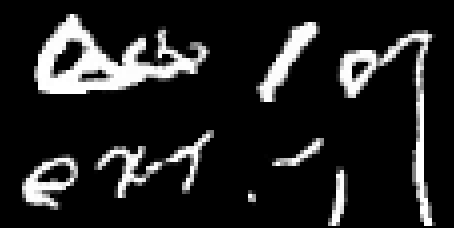

In [2]:
with torch.no_grad():
    with torch.autocast(device, dtype):  # type: ignore
        img = to_img(
            model.sample(
                shape=img_shape,
                aux=model.get_class_aux(
                    img_shape[-2:], loop(torch.arange(model._aux_channels), img_shape[0])
                ),
                depth_first=True,
            ),
            scale=4,
            cols=model.num_classes,
        )
        ipd.display(img)


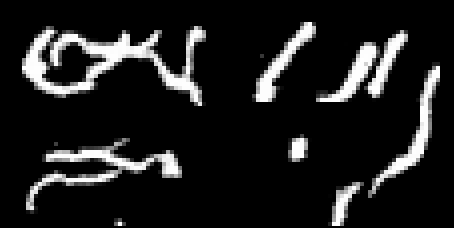

In [3]:
with torch.no_grad():
    with torch.autocast(device, dtype): # type: ignore
        img = to_img(
            model.sample(
                shape=img_shape,
                aux=model.get_class_aux(
                    img_shape[-2:], loop(torch.arange(model._aux_channels), img_shape[0])
                ),
                depth_first=False,
            ),
            scale=4,
            cols=model.num_classes,
        )
        ipd.display(img)
